# Exercises - GEO4902-01 - General modeling concepts

[Save google-collab as jupyter notebook, with your name in the filename, and upload on canvas]

# Exercise 01B - Access and plot AROME MetCoOp and ECMWF IFS forecasts

## Example for an extreme precipitation event in October 2014 in West Norway

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import cartopy as cy
from cmcrameri import cm

##### Specifiy input fields: AROME MetCoOp and ECMWF IFS forecasts

In [10]:
day='26'; month='10'; year='2014'; HH='12'

url='https://thredds.met.no/thredds/dodsC/aromemetcoopstarc/'+str(year)+'/'+str(month)+'/'+str(day)+'/AROME_MetCoOp_'+str(HH)+'_fp.nc_'+str(year)+str(month)+str(day)
arome = xr.open_dataset(url)
print(arome)

url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/Arctic.ECMWF_extracted_'+str(year)+str(month)+str(day)+'T'+str(HH)+'Z.nc'
ecifs =  xr.open_dataset(url)

<xarray.Dataset> Size: 39GB
Dimensions:                                                             (
                                                                         time: 67,
                                                                         pressure: 11,
                                                                         height_above_msl: 1,
                                                                         height0: 1,
                                                                         height1: 1,
                                                                         ...
                                                                         hybrid1: 1,
                                                                         grib1_vLevel200: 1,
                                                                         grib1_vLevel5: 1,
                                                                         grib1_vLevel8: 1,
                           

### Find a specific point and plot the forecast. 
###### Note AROME MetCoOp is on an irregular grid, so the xarray.sel functionality does not work. But it does work for the ECMWF IFS grid (see below)

In [3]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    y, x = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    y=int(y)
    x=int(x)
    return (y,x)

In [4]:
lat0=60.3833; lon0=5.9500 # Kvamskogen in Western Norway

[yloc,xloc] = findindex(arome.latitude,arome.longitude,lat0,lon0) # from regional model AROME MetCoOp

print(float(arome.latitude[yloc,xloc]))
print(float(arome.longitude[yloc,xloc]))

60.40058422516406
5.967753949175239


/tmp/ipykernel_646576/4120774711.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)
/tmp/ipykernel_646576/4120774711.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)


### The ECMWF IFS precipitation is subdivided into large scale or stratiform precipitation (LSP) and convective precipitation (TP-LSP)

In [5]:
ecifs

<xarray.Dataset> Size: 396MB
Dimensions:  (time: 67, lon: 961, lat: 256)
Coordinates:
  * time     (time) datetime64[ns] 536B 2014-10-26T12:00:00 ... 2014-10-29T06...
  * lon      (lon) float64 8kB -60.0 -59.88 -59.75 -59.62 ... 59.75 59.88 60.0
  * lat      (lat) float64 2kB 57.06 57.19 57.31 57.44 ... 88.69 88.81 88.94
Data variables:
    SP       (time, lat, lon) float32 66MB ...
    U10M     (time, lat, lon) float32 66MB ...
    V10M     (time, lat, lon) float32 66MB ...
    T2M      (time, lat, lon) float32 66MB ...
    TP       (time, lat, lon) float32 66MB ...
    LSP      (time, lat, lon) float32 66MB ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.8 (ht...
    Conventions:                     CF-1.6
    history:                         Tue Jun 30 14:30:09 2020: cdo -sellonlat...
    institution:                     European Centre for Medium-Range Weather...
    CDO:                             Climate Data Operators version 1.9.8 (ht...
    DODS_EXTRA.Unlimited_Dimension:  time

In [6]:
pp_acc_point_arome = arome.precipitation_amount_acc.isel(height0=0,y=yloc,x=xloc)
pp_acc_point_ecifs = ecifs.sel(lat=lat0,lon=lon0,method='nearest')

Text(0.5, 1.0, 'Kvamskogen Accumulated Precipitation Forecast')

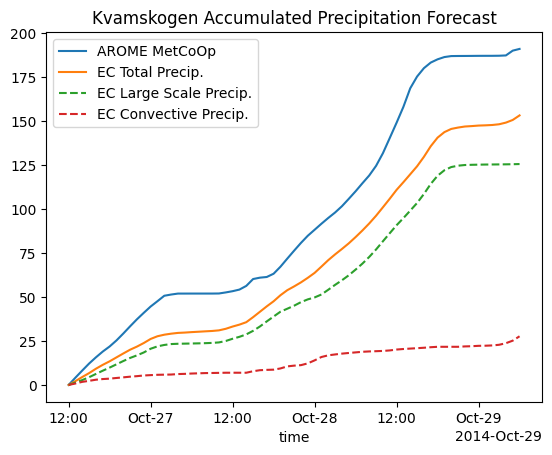

In [7]:
pp_acc_point_arome.plot(x='time', linestyle='-', label='AROME MetCoOp')
(pp_acc_point_ecifs.TP*1000).plot(x='time', linestyle='-',label='EC Total Precip.')
(pp_acc_point_ecifs.LSP*1000).plot(x='time', linestyle='--',label='EC Large Scale Precip.')
((pp_acc_point_ecifs.TP-pp_acc_point_ecifs.LSP)*1000).plot(x='time',linestyle='--',label='EC Convective Precip.')

plt.legend()
plt.title("Kvamskogen Accumulated Precipitation Forecast")

### Plot the two accumulated precipitation forecasts on a map

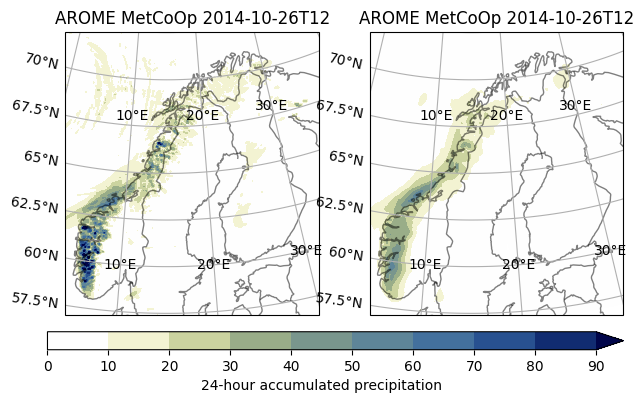

In [8]:
timestep=24 # 24-hour accumulated precipitation
levelsPP = range(0,100,10)


projection = cy.crs.LambertConformal(central_longitude =arome.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =arome.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = arome.projection_lambert.standard_parallel)
f, axsm = plt.subplots(1,2, subplot_kw={'projection' : projection}, figsize=(7.2,7.2), sharex=True, sharey=True)

for ax in axsm.flatten():
    ax.set_extent([5, 30, 57, 72], cy.crs.PlateCarree())
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels   = False
    gl.right_labels = False
    
arome.precipitation_amount_acc.isel(time=timestep,height0=0).plot.contourf(ax=axsm[0], transform=projection, cmap=cm.davos_r, extend='max',levels=levelsPP,add_colorbar=False)
axsm[0].set_title('AROME MetCoOp '+np.datetime_as_string(arome.time[0],unit='h'))

cf = (ecifs.TP.isel(time=timestep)*1000).plot.contourf(ax=axsm[1], transform=cy.crs.PlateCarree(), cmap=cm.davos_r, extend='max', levels=levelsPP, add_colorbar=False)
axsm[1].set_title ('AROME MetCoOp '+np.datetime_as_string(arome.time[0],unit='h'))

cbaxes = f.add_axes([0.1, 0.25, 0.8, 0.025])
cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='horizontal', extend='max',label='24-hour accumulated precipitation')